# **Przygotowali**
Jakub Matłacz
Kamil Trysiński

# 🔥 **Importy**

In [1]:
from our_library.our_reusable_methods import *
from our_library.plot_learning_curve import *

import pandas as pd
import seaborn as sns
import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV,HalvingRandomSearchCV,GridSearchCV,learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

# 🚀 **Tematyka projektu**
1. Stworzenie modelu regresji do przewidywania ilości spożywanego przez młodzież alkoholu zależnie od czynników środowiskowych. Tak wyuczony model, będący w stanie rozpoznawać trend w danych, można będzie używać jako narzędzie do wyznaczania ryzyka problemu alkoholowego na podstawie czynników środowiskowych.
2. Wykorzystany zbiór: [student-alcohol-consumption](https://data.world/data-society/student-alcohol-consumption)
3. Oryginalny zbiór zawiera dane z podziałem na szkoły i dwie tabele z danymi na temat ocen z matematyki oraz języka. Połączyliśmy obie tabelki w jedną i usunęliśmy niepotrzebne kolumny. Zmienne opisywane to spożycie w tygodniu oraz w weekendy. Połączyliśmy obie te zmienne w jedną - we wspólny współczynnik patologicznego spożycia, gdzie picie w tygodniu będzie liczone z wyższą wagą. Wszelkie zmiany na danych oryginalnych zostały opisane i wykonane w komórce w sekcji "Wstępne przygotowanie danych".

# 🌓 **Analiza Eksploracyjna**

## 🐇 **Wstępne Przygotowanie Danych**
Dane są zostały połączone w zbiór, który jest nam potrzebny, ale należy traktować je jako dane "oryginalne" - niepoddane normalizacji, czy innym inwazyjnym technikom. Jedyne co zostało zrobione to:
- usunięcie/połączenie pewnych kolumny
- zamiana atrybutów kategorycznych na ilościowe - w celu umożliwienia dalszej analizy zbioru i uczenia modelu
- zamiana nazw kolumn i posortowanie w celu większej przejrzystości w dalszych wizualizacjach
- zamiana typów danych na int64, ponieważ wszystkie wartości były całkowite (dane składają się z wielu atrybutów dobieranych przez człowieka w wyniku rozmowy z uczniem, więc są to pewne wskaźniki)

Ponadto połączono picie w tygodniu i weekend we wspólny wskaźnik problemu alkoholowego z wyższą wagą dla picia w tygodniu.

In [2]:
# wczytanie zbioru i usunięcie niepotrzebnych nam kolumn
d1 = pd.read_csv(r"data\student-mat.csv")
d2 = pd.read_csv(r"data\student-por.csv")

# łączymy obie tabelki w jedną
dataset = pd.concat([d1,d2], ignore_index=True)

# istnieje część wspólna obu tabelek, więc usuwamy kolumny niepotrzebne i z założenia różniące obie tabele
# usuwamy też duplikaty, czyli wystąpienia tych samych uczniów
dataset = dataset.drop(columns=["G1","G2","G3","paid"]).drop_duplicates(ignore_index=True)

# zakładamy, że picie w tygodniu 2.5 razy mocniej wskazuje na problem alkoholowy, ponieważ 5/2=2.5 co jest całkowicie arbitralnym wyborem
dataset['alc'] = 2.5 * dataset.Dalc + dataset.Walc

# usuwamy kolejne zbędne kolumny
dataset = dataset.drop(columns=["school","Dalc","Walc"])

# prosta binaryzacja atrybutów tam gdzie to możliwe,
# dobieramy wartości tak, aby rosły wraz ze stopniem depresji
for feature,value in zip(['sex','address','famsize','Pstatus'],['F','R','LE3','T']):
    dataset[feature] = dataset[feature].apply(lambda x:0 if x==value else 1)

# zamiast pisać ręcznie dla każdej jak powyżej
yes_no_columns = ['schoolsup','famsup','activities','nursery','higher','internet','romantic']
for c in yes_no_columns:
    dataset[c] = dataset[c].apply(lambda x:0 if x=="no" else 1)

# binaryzacja techniką one-hot-encode atrybytów kategorycznych
features_to_encode = ['Mjob','Fjob','reason','guardian']
encoder = OneHotEncoder()
results = encoder.fit_transform(dataset.loc[:,features_to_encode])

# zamiana starych atr. kat. na nowe one-hot-y
dataset_without_categoricals = dataset.drop(columns=features_to_encode).reset_index().drop(columns=["index"])
encoded_categoricals = pd.DataFrame(results.toarray(), columns=encoder.get_feature_names(features_to_encode)).reset_index().drop(columns=["index"])
dataset = pd.concat([dataset_without_categoricals, encoded_categoricals], axis=1)

# zamiana typów danych na int64
dataset = dataset.convert_dtypes()

# zamiana nazw kolumn na lowercase
dataset.columns = [c.lower() for c in dataset.columns]

# zamiana kolejności kolumn na alfabetyczną
dataset = dataset[sorted(dataset.columns)]

## **Braki W Danych**

W zbiorze danych nie ma żadnych braków danych, żadnych niewypełnionych wartości cech.

In [3]:
dataset.isna().sum().sum()

0

## 📺 **Oglądanie Danych**

Najwięcej punktów oddalonych ma cecha "nieobecności" i trzeba było je przyciąć, aby nie popsuć widoczności wykresu. Inną opcją była zamiana skali na log ale uważamy, że w tym przypadku nie miałoby to sensu, bo ciężko jest odczytać dokładne zakresy zmienności cech, które są dość małe.

Naturalnie wiele atrybutów binarnych (powstałych z kategorycznych) ma zakres zmienności od 0 do 1, bo przyjmują tylko te 2 wartości. "Niezdania" mają sporo punktów oddalonych, co ma sens, bo to jedna z tych rzeczy, które na poziomie liceum dotykają tylko nielicznych uczniów. Tak samo "relacje rodzinne". Co ciekawe "czas wolny" ma punkt oddalony - prawdopodobnie uczeń z dużą ilością zajęć dodatkowych.

Dodatkowo warto wspomnieć, że skoro dane były pobierane przez nauczyciela od ucznia na podstawie rozmowy, to na pewno są mocno zaszumione przez subiektywne odczucia ucznia odnośnie np. poziomu zdrowia czy relacji z rodziną. Ludzie mają tendencję do narzekania w tych sprawach, co może niesłusznie pogarszać wyniki.

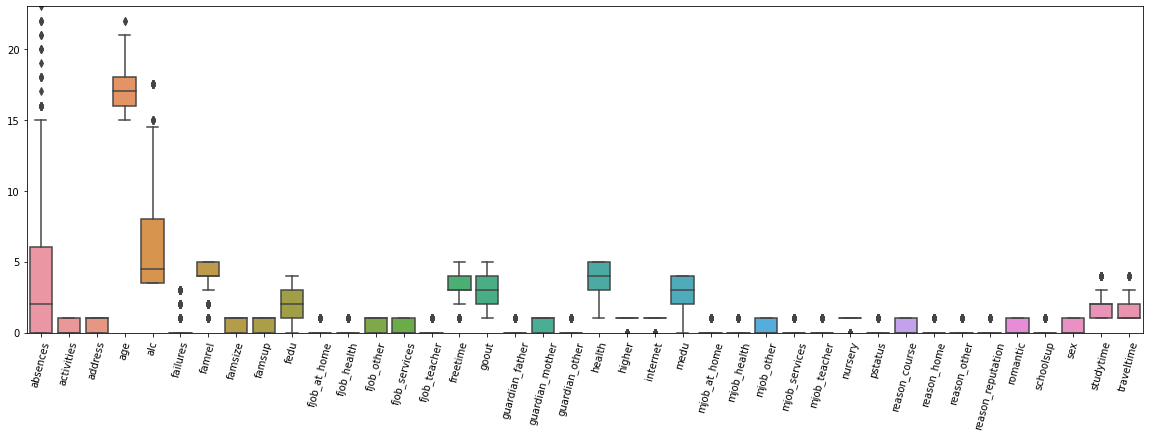

In [4]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)

# celowo ucinam punkty oddalone z wykresu
ax.set_ylim(0,23);
#ax.set_yscale('log')

Można powiedzieć, że zbiór jest niezbalansowany względem naszej zmiennej opisywanej (odpowiednik klasy w klasyfikacji). Wynik maksymalny to 17.5. Połowa osób ma wynik mniejszy od 4.5. Ćwierć osób ma wynik <4.5, 8>. Tylko pozostałe ćwierć osób ma wynik wyższy niż 8. Jest to jednak zrozumiałe i na całe szczęście tylko nieliczni mają problem w badanej próbie.

Jak widać najwięcej punktów oddalonych mają cechy takie jak:
1. nieobecności - większość uczniów prawie nie ma nieobecności
2. niezadania do następnej klasy - większości uczniów nigdy nie zdarzyło się niezdać do następnej klasy
3. relacje rodzinne - większość uczniów ma dobre relace rodzinne

Możliwe, że odchylenia od normy w tak ważnych dla rozwoju dziecka metrykach będą mieć spory wpływ na ryzyko alkoholowe.

Jak widać mamy około tysiąca obiektów w zbiorze. Zbiór naturlanie nie jest zbalsowany pod kątem zmiennej opisywanej "alc". Przyjmuje ona wartości z zakresu <3.5,17.5>. Wartości rosną wraz ze stopniem alkoholizmu. Tylko 25% uczniów pije więcej niż około połowa tego zakresu, czyli średni stopień problemu. Jeden uczeń (punkt oddalony) wyznacza górny limit skali stanowiąc dla nas naturalny punkt odniesienia (skala empiryczna).

count    959.000000
mean       6.094369
std        3.308938
min        3.500000
25%        3.500000
50%        4.500000
75%        8.000000
max       17.500000
Name: alc, dtype: float64


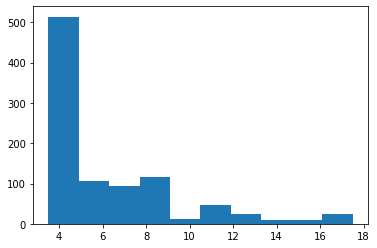

In [5]:
print(dataset.alc.describe())
plt.hist(dataset.alc);

In [6]:
# Obliczenia trwają bardzo długo dla takiej liczby atrybutów
# sns.pairplot(dataset)

Poniżej widać rozkłady wszystkich cech - wiele z nich jest binarnych lub ogólniej dyskretnych.

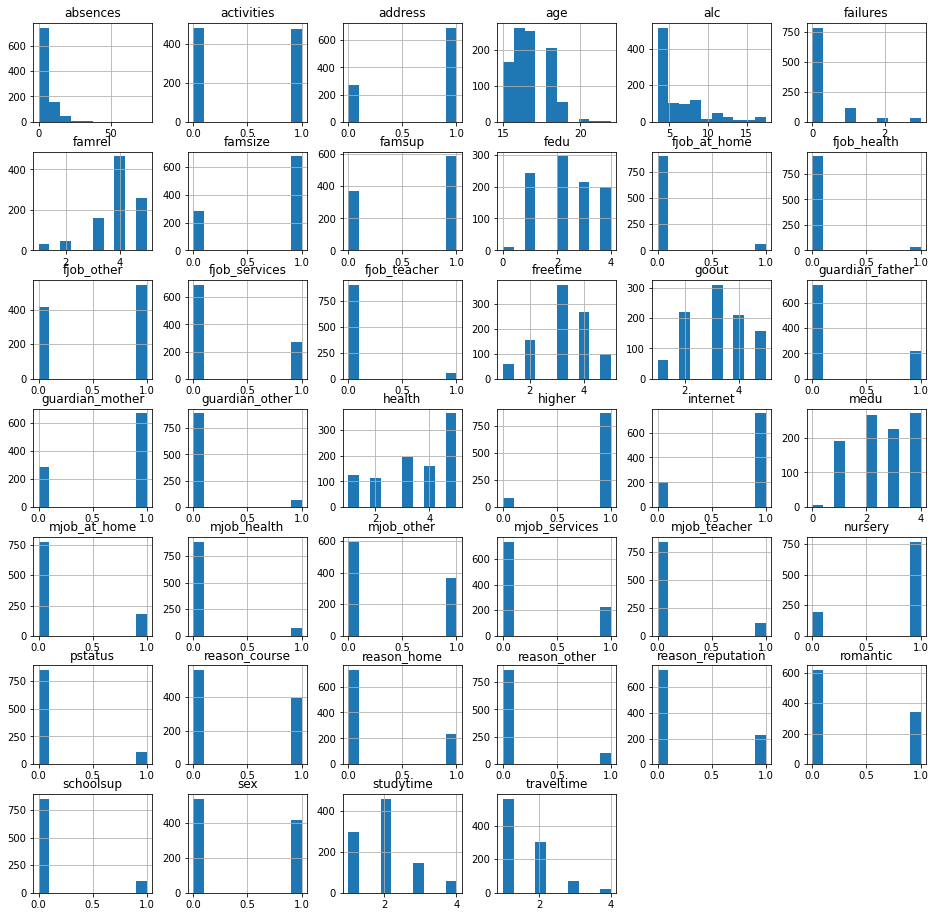

In [7]:
dataset.hist(figsize=(16,16));

Wiele rozkładów jest skośnych. Jest to jednak oczywiste i dobrze wpisuje się w naturę problemu, ponieważ przykładowo tylko garstka uczniów ma bardzo złe relacje z rodziną i trudno oczekiwać żeby zbiór był zbalansowany względem takiej cechy.

## 🍀 **Korelacje Cech**

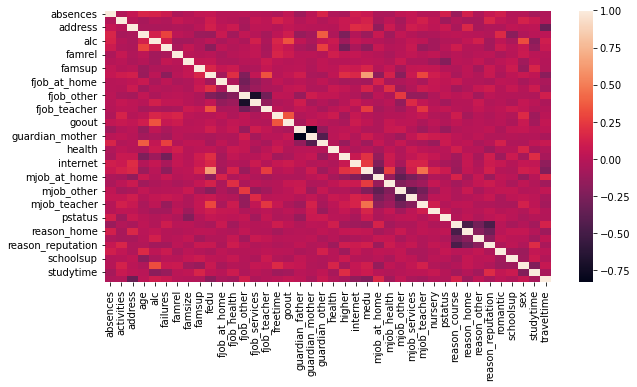

In [27]:
plt.figure(figsize=(10,5))
corr = dataset.corr()
sns.heatmap(data=corr);

In [28]:
corr_list = list(itertools.chain(*[[(r,c,corr.loc[r,c]) for r in corr.columns] for c in corr.columns]))
sorted_abs_corr_list = sorted(corr_list,key=lambda x:abs(x[2]), reverse=True)
sorted_abs_corr_list = list(filter(lambda x:x[0]!=x[1] and abs(x[2]) > 0.3, sorted_abs_corr_list))[::2]
pd.DataFrame(sorted_abs_corr_list, columns=['atr1','atr2','corr'])

,atr1,atr2,corr
0,guardian_mother,guardian_father,-0.830369
1,fjob_services,fjob_other,-0.711511
2,medu,fedu,0.637790
3,reason_home,reason_course,-0.477166
4,reason_reputation,reason_course,-0.467695
5,mjob_teacher,medu,0.450380
6,mjob_services,mjob_other,-0.430532
7,guardian_other,guardian_mother,-0.425006
8,mjob_at_home,medu,-0.380988
9,mjob_other,mjob_at_home,-0.379828


![title](https://miro.medium.com/max/932/1*Qz_gwy4ZaSZuOpl3IyO2HA.png)

Opis najbardziej znaczących korelacji:
- opieka ojca albo matki w rozwiedzonych parach
- edukacja matki i ojca
- praca nauczyciela i edukacja dla matek i ojców, ale w mniejszym stopniu
- praca matki w domu a wykształcenie
- tzw. inny opiekun dla uczniów, których wiek jest nietypowo wysoki w szkole średniej (dom dziecka, etc.)
- wyjścia z domu a alkohol i czas wolny
- czas podróży wyższy, jeśli mieszkają poza miastem
- płeć męska i alkohol
- wybór szkoły ze względu na reputację a ze względu na wygodę, czyli bliskość od domu

Nie chcemy jednak usuwać żadnej z cech, bo stopień korelacji jest zbyt niski, a każda cecha może pomagać klasyfikować złożoność problemu dla szczególnych uczniów.

# 🌓 **Opracowanie Modelu Regresji**

## 📐 **Skalowanie Danych**

Wiele cech po wstępnym przetworzeniu jest binarnych one-hot-encode. Wprowadzono takie rozwiązanie w celu możliwie mocnego zrównania wpływu różnych wartości atrybutu kategorycznego na wynik. Jednak mimo to wciąż będzie on obecny w małym stopniu, dlatego wartości cech binarnych rosną wraz z intucyjnym wpływem na depresję ucznia, czyli np. mieszkanie na wsi = 0, w mieście = 1 - na ogół w mieście ludzie czują się bardziej wyalienowani i samotni (jest to pewien bias z naszej strony, ale lepszy niż losowość).

Aby zrównać wpływ wszystkich cech - zostały znormalizowane do zakresu. Wybraliśmy zakres <1, 2>, bo pozwala uniknąć problemów z małymi liczbami i dzieleniem przez zero w metrykach. Również dla cech z punktami oddalonymi, ponieważ oczywistym jest, że zbiór nie może być zbalansowany pod kątem liczby alkoholików w szkole (całe szczęście), więc punkty oddalone są bardzo cenne - to właśnie zachowania anormalne mające ważny wpływ na wynik.

In [29]:
X = dataset.drop(columns=['alc'])
y = dataset['alc']

# skalowanie minmax, nie wpływa na nasze atr. binarne, ale wyrównuje wpływ z pozostałymi atrybutami
scaler = MinMaxScaler(feature_range=(1,2))
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

# brak skalowania zmiennej opisywanej dał gorsze wyniki, więc ją skalujemy
y = scaler.fit_transform(y.to_numpy().reshape(-1,1))
y = list(chain(*y.reshape(1,-1)))

# podział wyczyszczonego zbioru na części, wszystko robimy na treningowym (włącznie z walidacją), 
# testowy dopiero na sam koniec, dla już wybranego modelu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 👽 **Szukanie Modelu**
Przetestujemy następujące modele regresji:
- Multiple Linear Regression
- Multiple Polynomial Regression
- Ridge
- Lasso
- Elastic-Net
- SVM with kernel:

<ol>
<li>Poly</li>
<li>Linear</li>
<li>RBF</li>
</ol>

- DecisionTreeRegressor
- Least Angle Regression

Na początku będziemy dobierali parametry na podstawie założonych a priori wartości pozostałych parametrów. Będzie to przypominać jedną iteracjeę prostej optymalizacji przestrzeni hiperparametrów (startującej w określonym wektorze początkowym hiperparametrów), ale z wieloma problemami. Może dałoby się napisać algorytm takiej optymalizacji rozwiązując problem poruszania się po skośnych drogach w krajobrazie optymalizacyjnym, ale na chwilę obecną będzie to służyć pewnemu porównaniu.

Wykresy pomogą nam później wybrać zakresy wartości do przeszukiwania kombinacji HP. Następnie porównamy oba podejścia, ale pierwsze służy głównie stworzeniu pewnego zrozumienia doboru HP.

Zdecydowaliśmy się użyć MAE, ponieważ jest częścią wbudowanych funkcji sklearn, natomiast wynikiem testowania będzie MAPE.

In [30]:
# zapisanie najlepszych dobranych parametrów, modeli oraz wynikow testowania
models_parameters = []

### **Dummy Regressor**

In [31]:
quantile_strategies = [{"strategy":"quantile", "quantile" : q} for q in np.arange(0,1,0.1)]
constant_strategies = [{"strategy":"constant", "constant":c} for c in np.arange(0,1,0.1)]
strategies = quantile_strategies + constant_strategies + [{"strategy":"mean"}]
dummy_errors = []

for s in strategies:
    dummy = DummyRegressor(**s)
    error,_ = test_model(dummy,X_train,y_train,X_test,y_test)
    dummy_errors.append((dummy,error))

In [32]:
d = sorted(dummy_errors,key=lambda x:x[1])
d

[(DummyRegressor(quantile=0.4, strategy='quantile'), 11.975655366851223),
 (DummyRegressor(quantile=0.5, strategy='quantile'), 11.975655366851223),
 (DummyRegressor(quantile=0.0, strategy='quantile'), 12.56616723128334),
 (DummyRegressor(quantile=0.1, strategy='quantile'), 12.56616723128334),
 (DummyRegressor(quantile=0.2, strategy='quantile'), 12.56616723128334),
 (DummyRegressor(quantile=0.30000000000000004, strategy='quantile'),
  12.56616723128334),
 (DummyRegressor(quantile=0.6000000000000001, strategy='quantile'),
  13.051810169085726),
 (DummyRegressor(), 14.496503191644566),
 (DummyRegressor(quantile=0.7000000000000001, strategy='quantile'),
  16.799103219882568),
 (DummyRegressor(quantile=0.8, strategy='quantile'), 20.31692234567481),
 (DummyRegressor(constant=array(0.9), strategy='constant'), 21.30955050815502),
 (DummyRegressor(constant=array(0.8), strategy='constant'), 30.0529337850267),
 (DummyRegressor(constant=array(0.7), strategy='constant'), 38.7963170618983),
 (DummyR

Jak widać dla różnych dummy strategii mamy wyniki błędu MAPE w zakresie od ok. 12% do 100%. Oznacza to, że nasz ostateczny model z całą pewnością musi być znacznie lepszy niż najniższa wartość dummy błędu.

Najlepsze wyniki dummy są dla strategii przewidywania zawsze medianowego wyniku "alc". Oznacza to, że większość wartości w zbiorze testowym jest bliskie medianie wartości ze zbioru treningowego.

###  **Wieloraka Regresja Liniowa**
Nie posiada żadnych hiperparametrów.

In [14]:
model = LinearRegression()
score,train_score = test_model(model,X_train,y_train,X_test,y_test,silent=False)

Test score = 11.583736020387482 and train score = 11.711853232584245


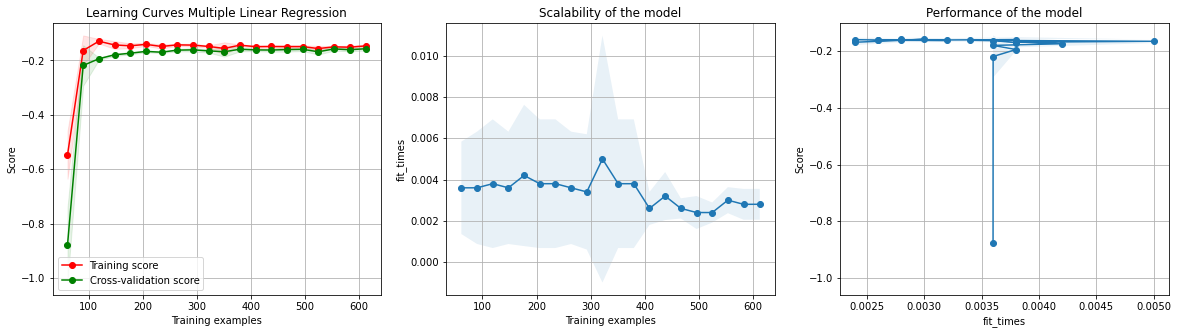

In [15]:
plot_learning_curve(
    estimator = LinearRegression(),
    title = "Learning Curves Multiple Linear Regression",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
);

Jak widać wynik testowania jest tylko nieco lepszy niż dla najlepszego dummy modelu. Krzywa uczenia wskazuje nam, że wielkość zbioru treningowego jest dostateczna dla tego typu modelu (więcej się nie nauczy, nie zyska na większej ilości danych). Jest również skalowalny, choć nie zyska dzięki temu na dokładności.

### Wieloraka Regresja Wielomianowa

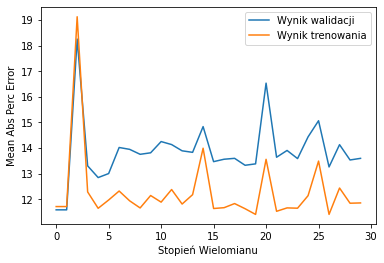

In [16]:
model = LinearRegression()
errors = []

for degree in range(30):
    X_train_extended,X_test_extended = [extend_to_poly_features(X,degree) for X in [X_train,X_test]]
    error = test_model(model,X_train_extended,y_train,X_test_extended,y_test)
    errors.append(error)

plt.plot(errors)
plt.xlabel("Stopień Wielomianu")
plt.ylabel("Mean Abs Perc Error")
plt.legend(["Wynik walidacji","Wynik trenowania"])

In [17]:
sorted(zip(range(50),errors),key=lambda x:x[1][0])[0]

(0, (11.583736020387482, 11.711853232584245))

Najlepszy model dla stopnia 0, tylko trochę lepszy wynik niż dummy - model się nie nadaje.

### Regresja Grzbietowa

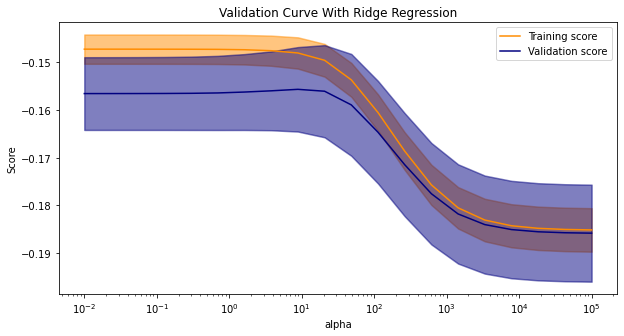

Best Parameter = 8.858667904100823 And Best Score = -0.15564510861327546


In [18]:
alpha, best_score, _,_ = plot_validation_curve(
    model = Ridge(random_state=1),
    model_name = "Ridge Regression",
    X = X_train, y = y_train,
    param_range = np.logspace(-2,5,20),
    param_name = "alpha",
    xscale = "log"
)

In [19]:
model = Ridge(random_state=1,alpha=alpha)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"alpha" : alpha}
save_model("Ridge",parameters,model,score,models_parameters)

Test score = 11.932549044314372 and train score = 11.925504574514143


<module 'matplotlib.pyplot' from 'C:\\Users\\01153072\\Anaconda3\\envs\\MED\\lib\\site-packages\\matplotlib\\pyplot.py'>

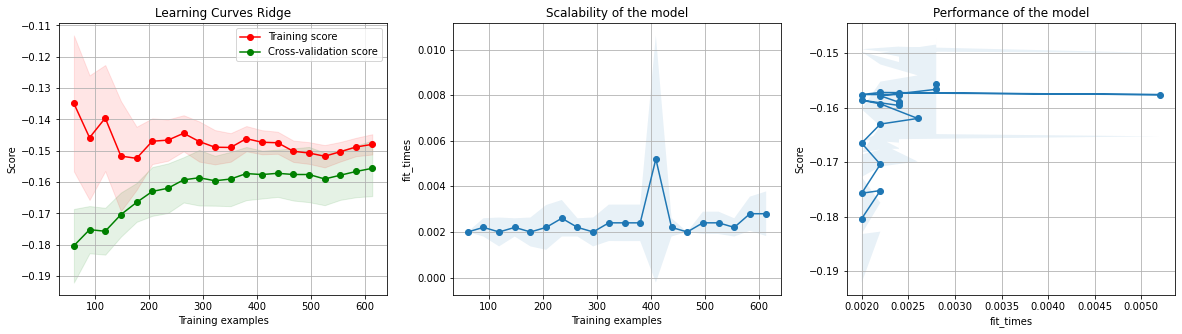

In [20]:
plot_learning_curve(
    estimator = Ridge(random_state=1,alpha=alpha),
    title = "Learning Curves Ridge",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

In [21]:
model = Ridge(random_state=1, alpha=alpha).fit(X_train,y_train)
dict(sorted(zip(X_train.columns,model.coef_),key=lambda x:abs(x[1]),reverse=True))

{'goout': 0.22297844619981394,
 'sex': 0.1295968838676707,
 'famrel': -0.11733519262459137,
 'absences': 0.09672592384179321,
 'age': 0.07754326734407833,
 'mjob_health': -0.06551097728371742,
 'studytime': -0.05419910667135199,
 'fjob_services': 0.05004109027714709,
 'fjob_teacher': -0.046861639368778026,
 'nursery': -0.043339445621103534,
 'reason_other': 0.04157139396444307,
 'health': 0.03659620632094705,
 'mjob_teacher': 0.03399118502987081,
 'traveltime': 0.033452549249586884,
 'famsize': -0.03238957372575075,
 'reason_reputation': -0.027524854085909444,
 'fjob_at_home': -0.027465315535618914,
 'guardian_mother': -0.026750004837391858,
 'fedu': 0.025295157984583108,
 'reason_course': -0.02476973998972257,
 'address': -0.02440155799075772,
 'fjob_health': 0.023444239781607975,
 'romantic': 0.02329512878315677,
 'mjob_services': 0.022812382020582393,
 'activities': -0.020512180875489772,
 'internet': 0.017770987612334775,
 'guardian_other': 0.015500426343185974,
 'mjob_at_home': 0.

Skalowalny i nie zyska zbyt wiele na zwiększeniu zbioru. Najmniej ważne są cechy takie jak:
- chęć dalszego kształcenia
- wsparcie rodziny (co brzmi dość dziwnie)
- ilość wolnego czasu
- niezdania

Najwyższy wpływ mają cechy:
- liczba wyjść (czy pije, bo wychodzi czy wychodzi, by się napić?)
- płeć (wcześniej podane wyższą liczbę płci mężczyzna)
- relacje rodzinne obniżają ryzyko
- nieobecności podwyższają ryzyko (lub świadczą o już istniejącym problemie)
- wiek, starsi siłą rzeczy czują przyzwolenie do picia

### Regresja Lasso

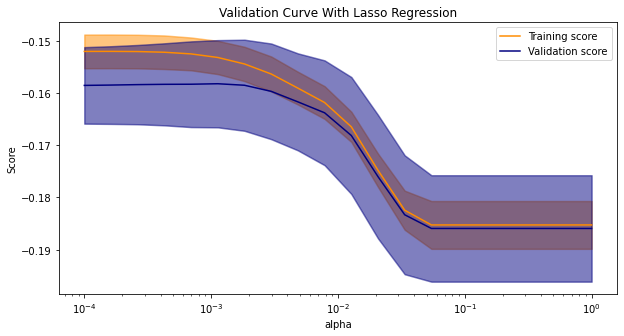

Best Parameter = 0.0011288378916846883 And Best Score = -0.1582312777020095


In [22]:
alpha, best_score, _,_ = plot_validation_curve(
    model = Lasso(random_state=1,positive=True),
    model_name = "Lasso Regression",
    X = X_train, y = y_train,
    param_range = np.logspace(-4,0,20),
    param_name = "alpha",
    xscale = "log"
)

In [23]:
model = Lasso(random_state=1,positive=True,alpha=alpha)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"alpha" : alpha}
save_model("Lasso",parameters,model,score,models_parameters)

Test score = 12.188562278471354 and train score = 12.348113358449504


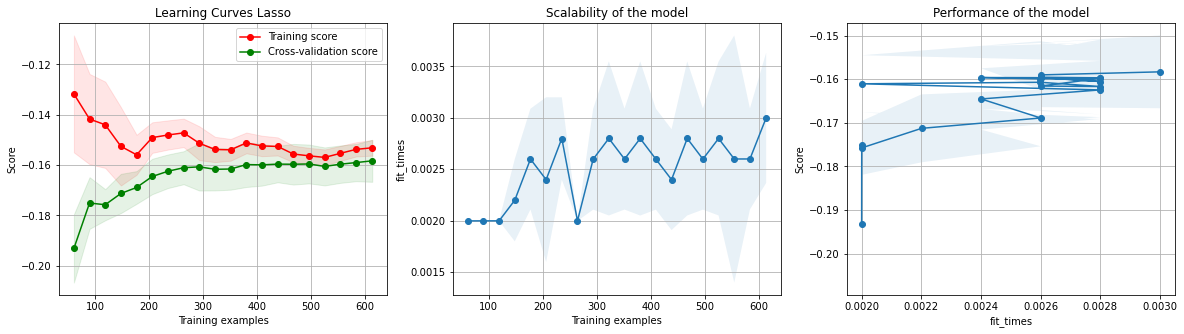

In [24]:
plot_learning_curve(
    estimator = Lasso(random_state=1,positive=True,alpha=alpha),
    title = "Learning Curves Lasso",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
);

In [25]:
model = Lasso(random_state=1,positive=True,alpha=alpha).fit(X_train,y_train)
dict(sorted(zip(X_train.columns,model.coef_),key=lambda x:abs(x[1]),reverse=False))

{'activities': 0.0,
 'address': 0.0,
 'famrel': 0.0,
 'famsize': 0.0,
 'famsup': 0.0,
 'fedu': 0.0,
 'fjob_at_home': 0.0,
 'fjob_health': 0.0,
 'fjob_teacher': 0.0,
 'freetime': 0.0,
 'guardian_mother': 0.0,
 'higher': 0.0,
 'medu': 0.0,
 'mjob_health': 0.0,
 'mjob_other': 0.0,
 'nursery': 0.0,
 'pstatus': 0.0,
 'reason_course': 0.0,
 'reason_reputation': 0.0,
 'schoolsup': 0.0,
 'studytime': 0.0,
 'internet': 0.0006610582178194837,
 'failures': 0.011405457488266327,
 'fjob_other': 0.012050426068926572,
 'romantic': 0.016357518598759946,
 'mjob_at_home': 0.017667317828282906,
 'mjob_services': 0.02395684229984718,
 'mjob_teacher': 0.02396460914155559,
 'health': 0.024676852395964233,
 'guardian_father': 0.030328604976443893,
 'reason_home': 0.030362554808744772,
 'guardian_other': 0.03223032721915292,
 'traveltime': 0.04232839931314195,
 'fjob_services': 0.05854703751794367,
 'reason_other': 0.06257989337250926,
 'age': 0.0814090114974759,
 'sex': 0.1390993110223196,
 'absences': 0.146

Podobnie jak przy regresji grzbietowej, tylko wynik jest gorszy (taki sam jak w dummy). Najwyższy wpływ mają te same cechy co w regresji grzbietowej.

### Elastic-Net
- alpha
- l1_ratio

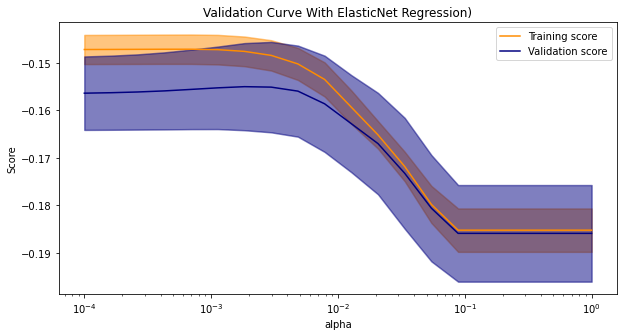

Best Parameter = 0.0018329807108324356 And Best Score = -0.15500209894708247


In [26]:
alpha, best_score, _,_ = plot_validation_curve(
    model = ElasticNet(random_state=1),
    model_name = f"ElasticNet Regression)",
    X = X_train, y = y_train,
    param_range = np.logspace(-4,0,20),
    param_name = "alpha",
    xscale = "log"
)

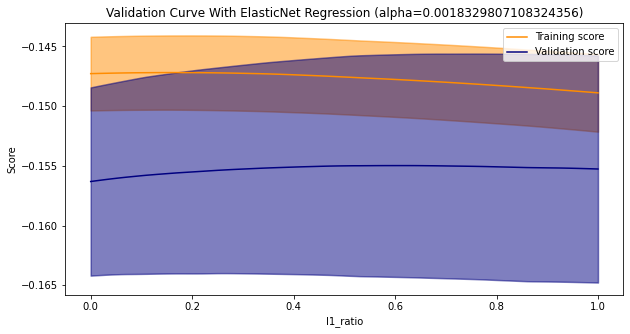

Best Parameter = 0.62 And Best Score = -0.15497930431613957


In [27]:
l1_ratio, best_score, _,_ = plot_validation_curve(
    model = ElasticNet(random_state=1,alpha=alpha),
    model_name = f"ElasticNet Regression (alpha={alpha})",
    X = X_train, y = y_train,
    param_range = np.arange(0,1.01,0.01),
    param_name = "l1_ratio",
    xscale = "lin"
)

In [28]:
model = ElasticNet(random_state=1,alpha=alpha,l1_ratio=l1_ratio)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"alpha" : alpha, "l1_ratio" : l1_ratio}
save_model("ElasticNet",parameters,model,score,models_parameters)

Test score = 11.858088623215638 and train score = 11.91413877871074


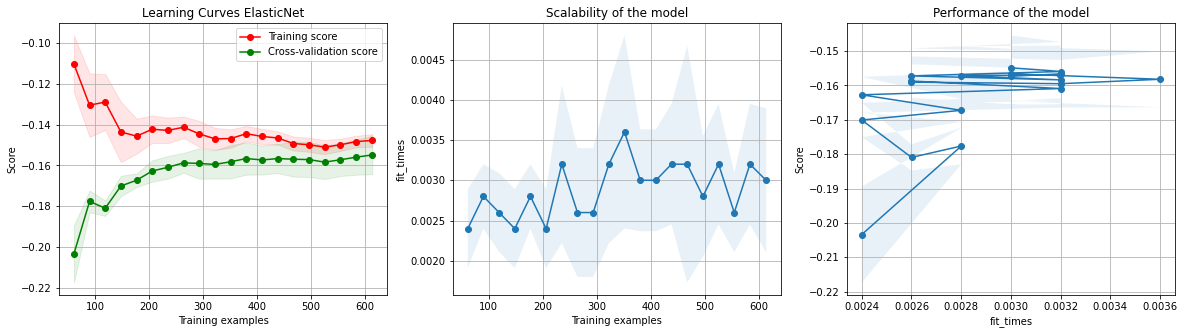

In [29]:
plot_learning_curve(
    estimator = ElasticNet(random_state=1,alpha=alpha,l1_ratio=l1_ratio),
    title = "Learning Curves ElasticNet",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
);

Podobnie jak w regresji grzbietowej i Lasso.

### SVM Z Jądrem Wielomianowym

- degree
- gamma
- C
- epsilon

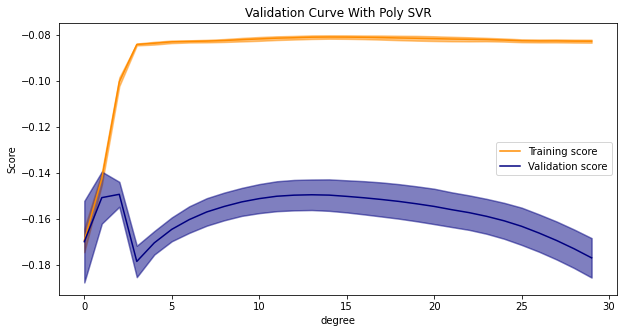

Best Parameter = 2 And Best Score = -0.14923897748024398


In [31]:
degree, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly"),
    model_name = "Poly SVR",
    X = X_train, y = y_train,
    param_range = np.arange(0,30),
    param_name = "degree",
    xscale = "lin"
)

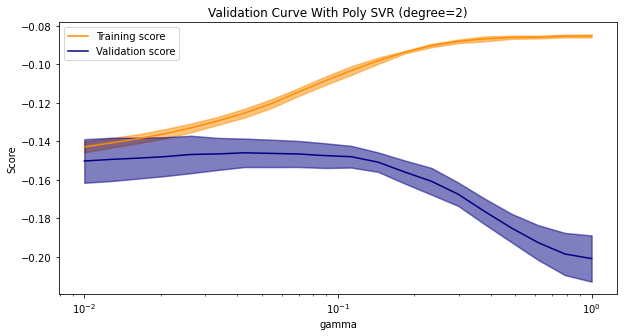

Best Parameter = 0.04281332398719394 And Best Score = -0.14605207001699566


In [32]:
gamma, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree),
    model_name = f"Poly SVR (degree={degree})",
    X = X_train, y = y_train,
    param_range = np.logspace(-2,0,20),
    param_name = "gamma",
    xscale = "log"
)

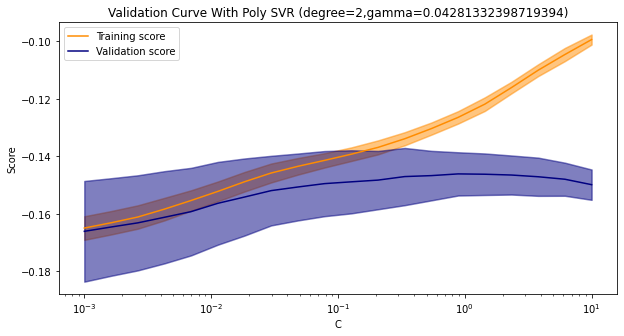

Best Parameter = 0.8858667904100823 And Best Score = -0.14613056018345993


In [33]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree,gamma=gamma),
    model_name = f"Poly SVR (degree={degree},gamma={gamma})",
    X = X_train, y = y_train,
    param_range = np.logspace(-3,1,20),
    param_name = "C",
    xscale = "log"
)

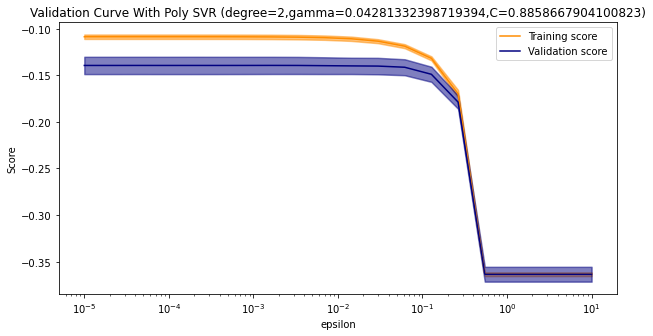

Best Parameter = 0.001623776739188721 And Best Score = -0.13948235837844264


In [34]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree,gamma=gamma,C=C),
    model_name = f"Poly SVR (degree={degree},gamma={gamma},C={C})",
    X = X_train, y = y_train,
    param_range = np.logspace(-5,1,20),
    param_name = "epsilon",
    xscale = "log"
)

In [35]:
model = SVR(kernel="poly",degree=degree,gamma=gamma,C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"degree":degree,"gamma":gamma,"C":C,"epsilon":epsilon}
save_model("SVR_poly",parameters,model,score,models_parameters)

Test score = 10.364555454701746 and train score = 8.03893801871755


<module 'matplotlib.pyplot' from 'C:\\Users\\01153072\\Anaconda3\\envs\\MED\\lib\\site-packages\\matplotlib\\pyplot.py'>

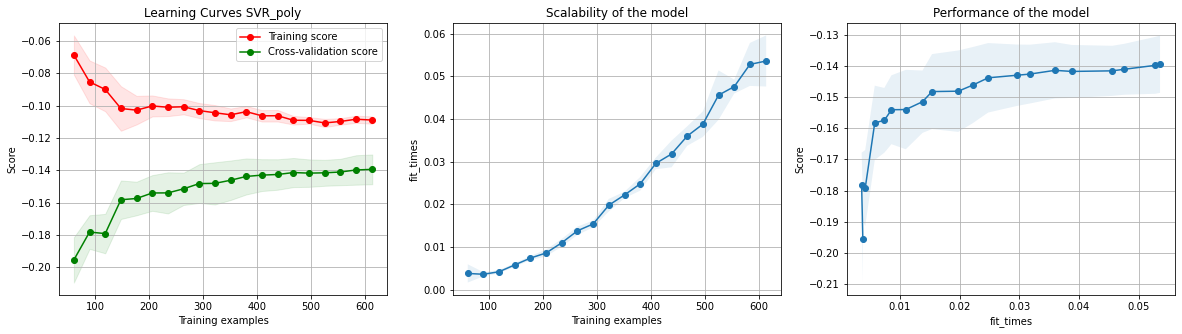

In [36]:
plot_learning_curve(
    estimator = SVR(kernel="poly",degree=degree,gamma=gamma,C=C,epsilon=epsilon),
    title = "Learning Curves SVR_poly",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Zdecydowanie lepsze wyniki niż dla klasycznej regresji. Spadek do błędu ok. 10%. Model zdecydowanie zyskałby na zwiększeniu zbioru uczącego, jednak nie jest zbyt dobrze skalowalny (typowe dla SVMów).

### SVM Z Jądrem Liniowym

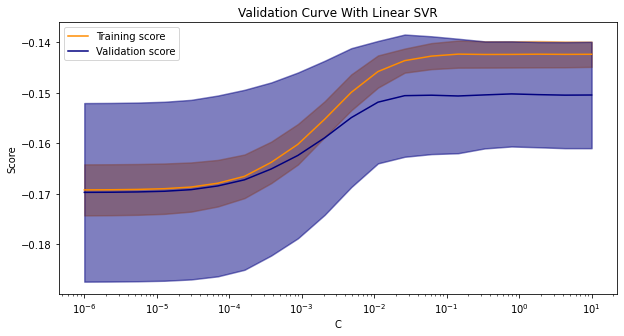

Best Parameter = 0.7847599703514607 And Best Score = -0.15024769483603562


In [38]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="linear"),
    model_name = "Linear SVR",
    X = X_train, y = y_train,
    param_range = np.logspace(-6,1,20),
    param_name = "C",
    xscale = "log"
)

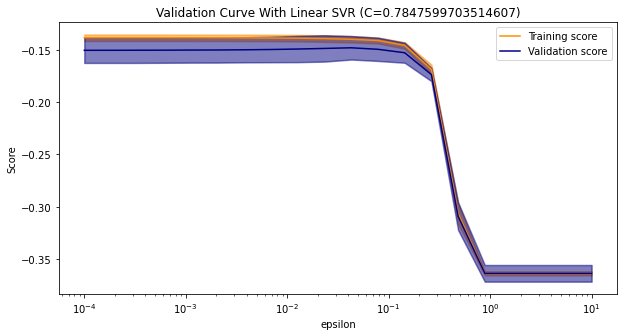

Best Parameter = 0.04281332398719392 And Best Score = -0.14801006985226936


In [39]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="linear",C=C),
    model_name = f"Linear SVR (C={C})",
    X = X_train, y = y_train,
    param_range = np.logspace(-4,1,20),
    param_name = "epsilon",
    xscale = "log"
)

In [40]:
model = SVR(kernel="linear",C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"C":C,"epsilon":epsilon}
save_model("SVR_linear",parameters,model,score,models_parameters)

Test score = 10.753301009803295 and train score = 10.76493803525155


<module 'matplotlib.pyplot' from 'C:\\Users\\01153072\\Anaconda3\\envs\\MED\\lib\\site-packages\\matplotlib\\pyplot.py'>

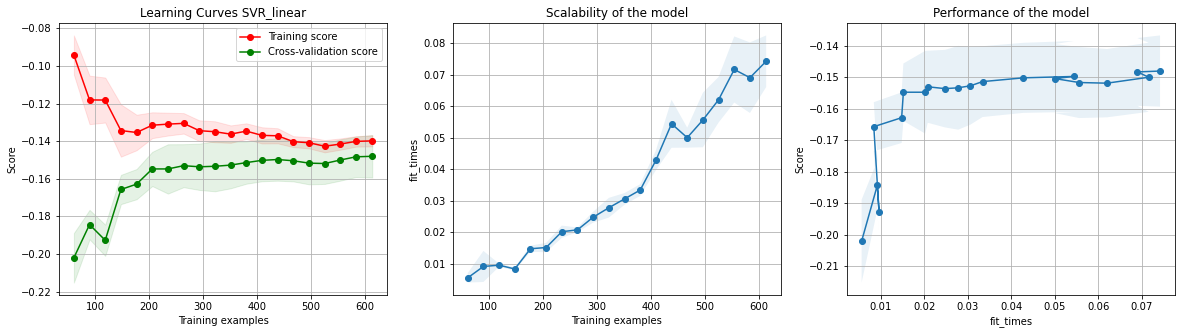

In [41]:
plot_learning_curve(
    estimator = SVR(kernel="linear",C=C,epsilon=epsilon),
    title = "Learning Curves SVR_linear",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Wynik znacznie gorszy niż z jądrem wielomianowym, nie zyska na zwiększeniu zbioru uczącego i źle skalowany. Już lepszy byłby zwykły liniowy.

### SVR Z Jądrem RBF
- gamma
- C
- epsilon

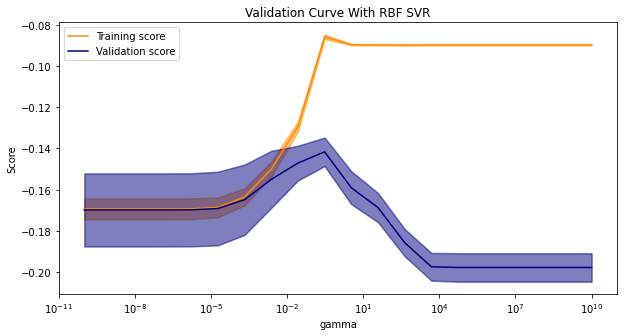

Best Parameter = 0.2976351441631313 And Best Score = -0.1416228880226579


In [43]:
gamma, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf"),
    model_name = "RBF SVR",
    X = X_train, y = y_train,
    param_range = np.logspace(-10,10,20),
    param_name = "gamma",
    xscale = "log"
)

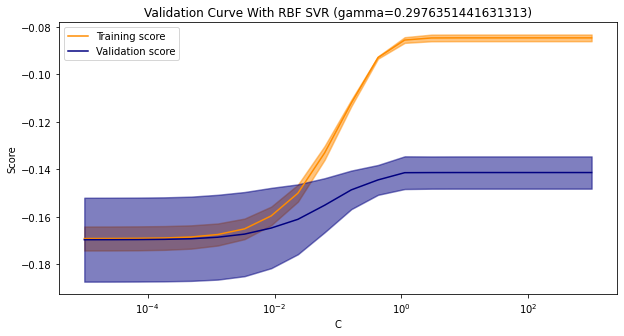

Best Parameter = 1000.0 And Best Score = -0.1414447573517331


In [44]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=gamma),
    model_name = f"RBF SVR (gamma={gamma})",
    X = X_train, y = y_train,
    param_range = np.logspace(-5,3,20),
    param_name = "C",
    xscale = "log"
)

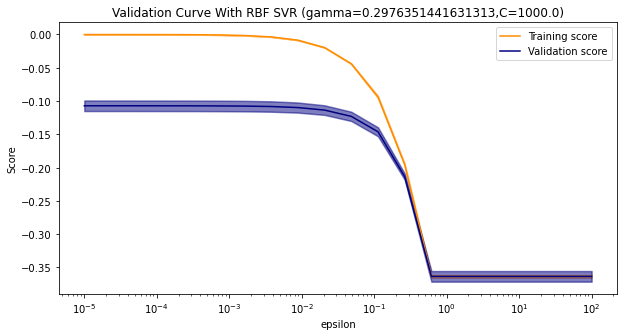

Best Parameter = 1e-05 And Best Score = -0.10722940786792709


In [45]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=gamma,C=C),
    model_name = f"RBF SVR (gamma={gamma},C={C})",
    X = X_train, y = y_train,
    param_range = np.logspace(-5,2,20),
    param_name = "epsilon",
    xscale = "log"
)

In [46]:
model = SVR(kernel="rbf",gamma=gamma,C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"gamma":gamma,"C":C,"epsilon":epsilon}
save_model("SVR_rbf",parameters,model,score,models_parameters)

Test score = 7.94119253155634 and train score = 0.014504027418102078


<module 'matplotlib.pyplot' from 'C:\\Users\\01153072\\Anaconda3\\envs\\MED\\lib\\site-packages\\matplotlib\\pyplot.py'>

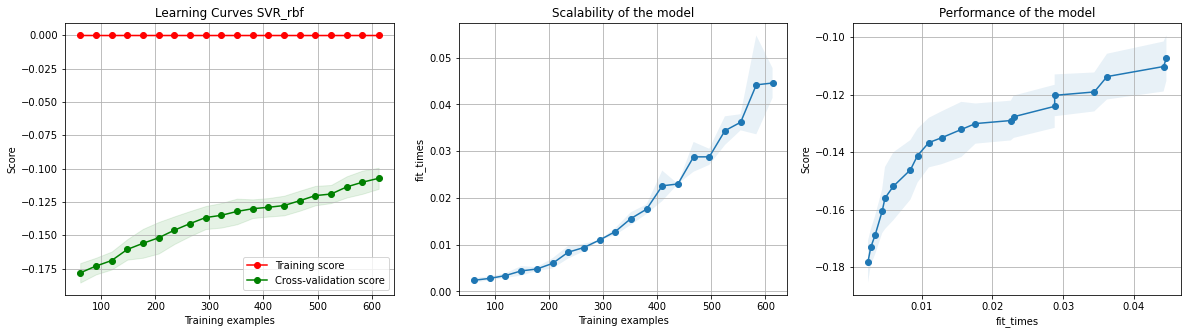

In [47]:
plot_learning_curve(
    estimator = SVR(kernel="rbf",gamma=gamma,C=C,epsilon=epsilon),
    title = "Learning Curves SVR_rbf",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Błąd testowania ok. 8% - najlepszy jak dotąd. Jeszcze bardziej potrzebuje większego zbioru danych i jeszcze gorzej skalowalny. Z większym zbiorem mógłby idealnie uchwycić wiedzę zawartą w danych, bo widać jaka jest różnica między walidacją a trenowaniem oraz widać jak szybko rośnie wynik walidacji.

### Regression Tree

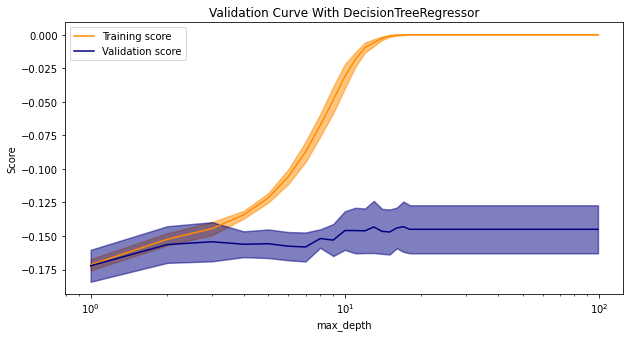

Best Parameter = 17 And Best Score = -0.14307328992202942


In [49]:
max_depth, best_score, _,_ = plot_validation_curve(
    model = DecisionTreeRegressor(random_state=1),
    model_name = "DecisionTreeRegressor",
    X = X_train, y = y_train,
    param_range = np.arange(1,100),
    param_name = "max_depth",
    xscale = "log"
)

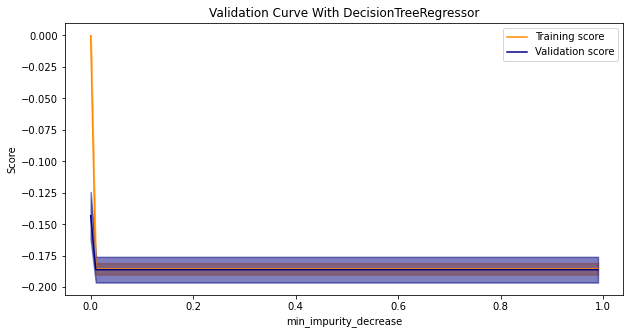

Best Parameter = 0.0 And Best Score = -0.14307328992202942


In [50]:
min_impurity_decrease, best_score, _,_ = plot_validation_curve(
    model = DecisionTreeRegressor(random_state=1,max_depth=max_depth),
    model_name = "DecisionTreeRegressor",
    X = X_train, y = y_train,
    param_range = np.arange(0,1,0.01),
    param_name = "min_impurity_decrease",
    xscale = "lin"
)

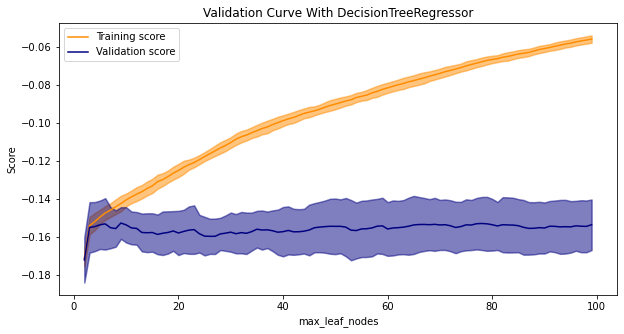

Best Parameter = 9 And Best Score = -0.15280315664623637


In [51]:
max_leaf_nodes, best_score, _,_ = plot_validation_curve(
    model = DecisionTreeRegressor(random_state=1,
        max_depth=max_depth,min_impurity_decrease=min_impurity_decrease),
    model_name = "DecisionTreeRegressor",
    X = X_train, y = y_train,
    param_range = np.arange(0,100,1),
    param_name = "max_leaf_nodes",
    xscale = "lin"
)

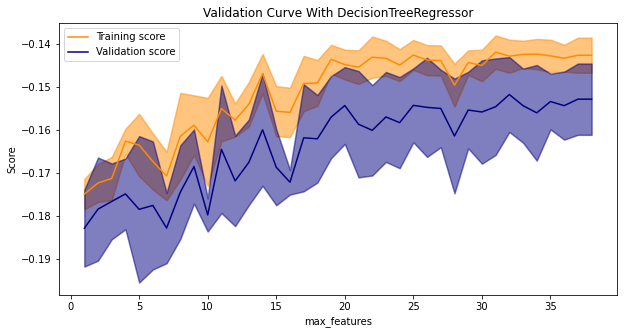

Best Parameter = 32 And Best Score = -0.1517183745555129


In [52]:
max_features, best_score, _,_ = plot_validation_curve(
    model = DecisionTreeRegressor(random_state=1,
        max_depth=max_depth,min_impurity_decrease=min_impurity_decrease,max_leaf_nodes=max_leaf_nodes),
    model_name = "DecisionTreeRegressor",
    X = X_train, y = y_train,
    param_range = np.arange(0,39,1),
    param_name = "max_features",
    xscale = "lin"
)

In [53]:
model = DecisionTreeRegressor(random_state=1,max_depth=max_depth,min_impurity_decrease=min_impurity_decrease,max_leaf_nodes=max_leaf_nodes,max_features=max_features)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {'max_depth':max_depth,'min_impurity_decrease':min_impurity_decrease,'max_leaf_nodes':max_leaf_nodes,'max_features':max_features}
save_model("DecisionTreeRegressor",parameters,model,score,models_parameters)

Test score = 13.902879807174495 and train score = 11.604452279075124


<module 'matplotlib.pyplot' from 'C:\\Users\\01153072\\Anaconda3\\envs\\MED\\lib\\site-packages\\matplotlib\\pyplot.py'>

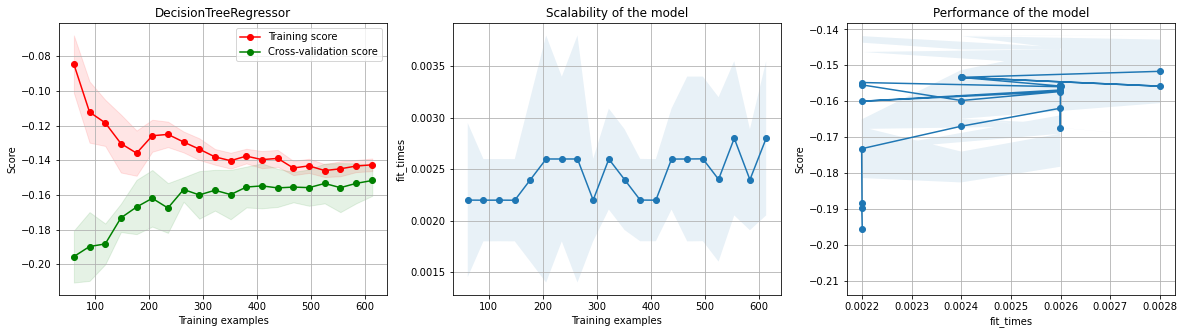

In [54]:
plot_learning_curve(
    estimator = DecisionTreeRegressor(random_state=1,max_depth=max_depth,min_impurity_decrease=min_impurity_decrease,max_leaf_nodes=max_leaf_nodes,max_features=max_features),
    title = "DecisionTreeRegressor",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

### Least Angle Regression

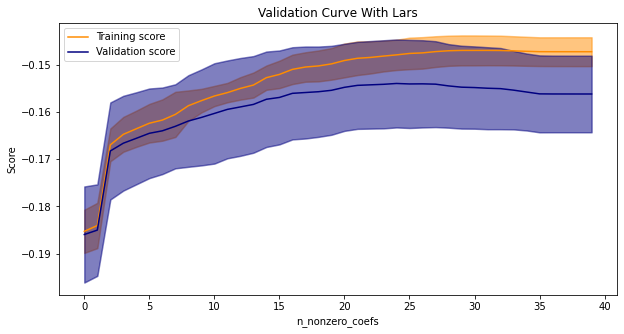

Best Parameter = 24 And Best Score = -0.15390796568227827


In [55]:
n_nonzero_coefs, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1),
    model_name = "Lars",
    X = X_train, y = y_train,
    param_range = np.arange(0,len(X_train.columns)+1),
    param_name = "n_nonzero_coefs",
    xscale = "lin"
)

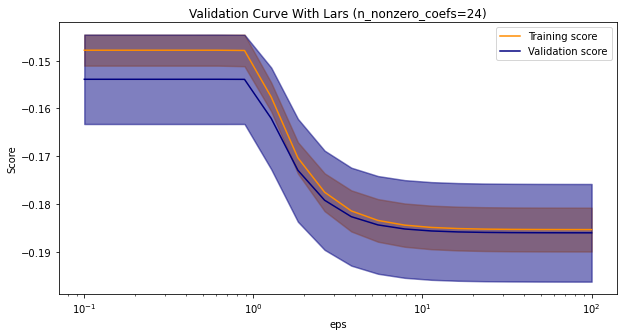

Best Parameter = 0.6158482110660264 And Best Score = -0.15390597217100144


In [56]:
eps, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=n_nonzero_coefs),
    model_name = f"Lars (n_nonzero_coefs={n_nonzero_coefs})",
    X = X_train, y = y_train,
    param_range = np.logspace(-1,2,20),
    param_name = "eps",
    xscale = "log"
)

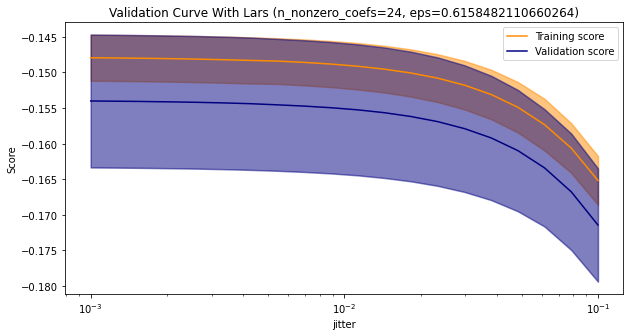

Best Parameter = 0.001 And Best Score = -0.1540197327565755


In [57]:
jitter, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=n_nonzero_coefs, eps=eps),
    model_name = f"Lars (n_nonzero_coefs={n_nonzero_coefs}, eps={eps})",
    X = X_train, y = y_train,
    param_range = np.logspace(-3,-1,20),
    param_name = "jitter",
    xscale = "log"
)

In [58]:
model = Lars(random_state=1,n_nonzero_coefs=n_nonzero_coefs,eps=eps,jitter=jitter)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"n_nonzero_coefs":n_nonzero_coefs,"eps":eps,"jitter":jitter}
save_model("Lars",parameters,model,score,models_parameters)

Test score = 11.745410966836564 and train score = 11.889602784466238


<module 'matplotlib.pyplot' from 'C:\\Users\\01153072\\Anaconda3\\envs\\MED\\lib\\site-packages\\matplotlib\\pyplot.py'>

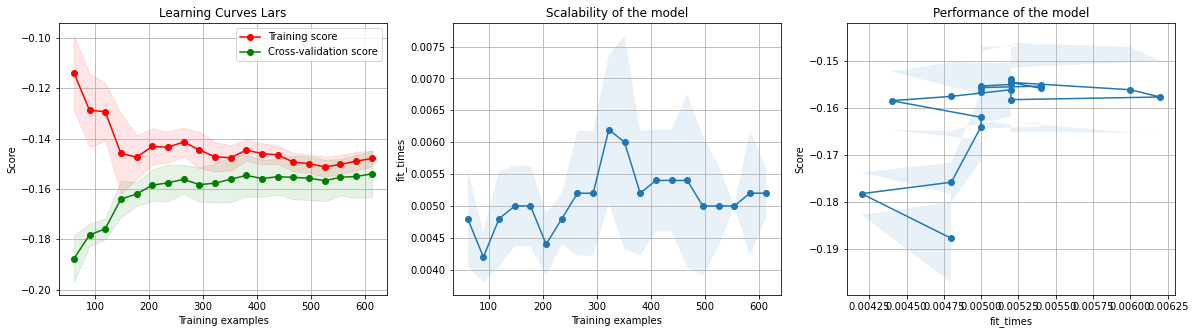

In [59]:
plot_learning_curve(
    estimator = Lars(random_state=1,n_nonzero_coefs=n_nonzero_coefs,eps=eps,jitter=jitter),
    title = "Learning Curves Lars",
    X = X_train, y = y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Nie zyska na zwiększeniu zbioru, dobrze skalowalny. Wynik bliski dummy.

## 🏅 **Najlepsze Modele**
Wybrane ręcznie najlepsze modele.

In [61]:
models_parameters = sorted(models_parameters, key=lambda x:x['error'])
models_parameters[0]

{'name': 'SVR_rbf',
 'parameters': {'gamma': 0.2976351441631313, 'C': 1000.0, 'epsilon': 1e-05},
 'model': SVR(C=1000.0, epsilon=1e-05, gamma=0.2976351441631313),
 'error': (7.94119253155634, 0.014504027418102078)}

## 😸 **Wyniki W Dziedzinie Kategorii**
Z rozumienia zbioru danych wyłaniamy 7 kategorii atrybutu opisywanego "alc": <br>
<ol>
<li>Prawie Wcale</li>
<li>Bardzo Mało</li>
<li>Mało</li>
<li>Średnio</li>
<li>Sporo</li>
<li>Dużo</li>
<li>Bardzo Dużo</li>
</ol>

Porówujemy najlepsze modele pod kątem pomyłek i metryki F1:

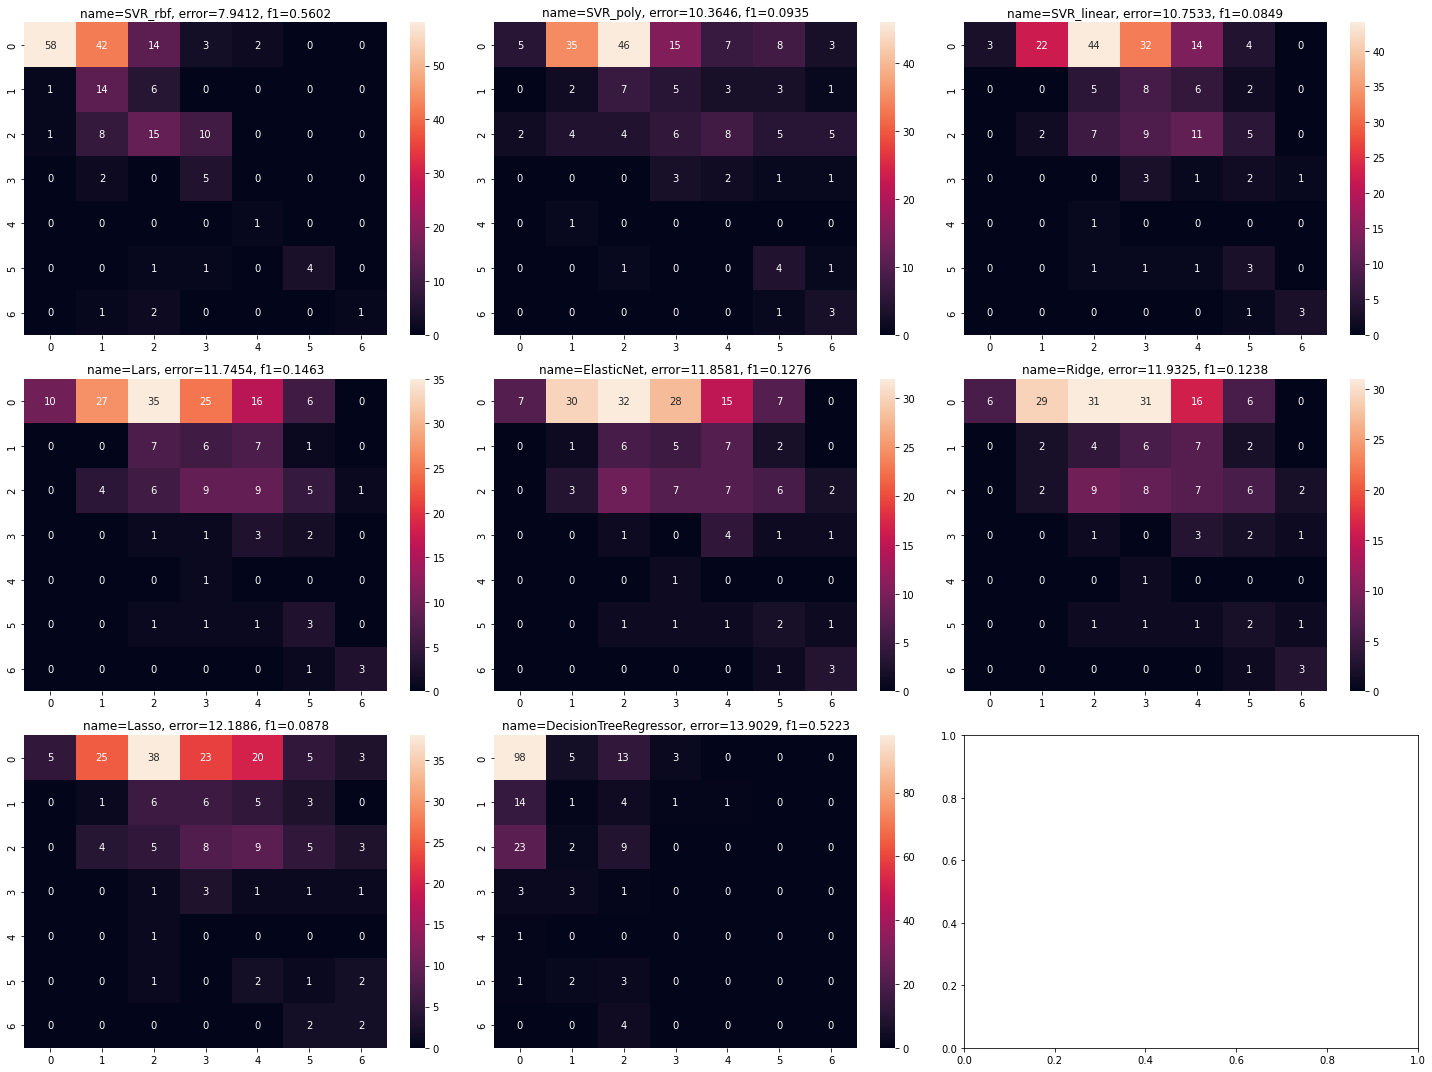

In [62]:
fig,axes = plt.subplots(3,3)
fig.set_figwidth(20)
fig.set_figheight(15)

for name,parameters,model,score,ax in [list(m.values()) + [ax] for m,ax in zip(models_parameters,chain(*axes))]:

    test_score = score[0]
    train_score = score[1]

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    categoricals = convert_to_categoricals(y_test,y_pred,7)
    conf = confusion_matrix(*categoricals)
    f1 = round(f1_score(*categoricals,average="weighted"),4)
    error = round(test_score,4)

    ax.set_title(f"name={name}, error={error}, f1={f1}")
    sns.heatmap(conf, annot=conf, ax=ax)

plt.tight_layout()

## 🤔 **Wnioski**

Najlepszy wynik udało się osiągnąć dla modelu SVM z jądrem RBF. Drugi, również godny uwagi model - SVM z jądrem wielomianowym. Błąd testowania najlepszego modelu wynosi ok. 0.0794, co stanowi bardzo dobry wynik, biorąc pod uwagę nasze dane. Błąd ok. 0.1 to połowa różnicy między kolejnymi stopniami spożycia alkoholu, więc wynik powinien być bardzo sensowny. W oryginalnych danych spożycie alkoholu było określane w skali 1-5 (very low, low, avg, high, very high). Po przeskalowaniu na zakres 0-1 - jednemu punktowi w skali odpowiada 0.2. Nasz błąd to około 0.1. Oznacza to, że nasz model nie myli się bardziej niż o pół stopnia w skali, czyli np. kogoś kto pije mało zaklasyfikuje w najgorszym razie jako w połowie drogi do pijącego bardzo mało lub średnio.

Największe błędy model osiąga dla osób, których warunki środowiskowe są bardzo trudne ale osoby te mają silny charakter i nie przesadzają z alkoholem pomimo trudnego życia (jest to bardzo optymistyczne spostrzeżenie). W dziedzinie kategorii nasz wybrany model również jest najlepszy i sądzimy, że zadowalający. Trochę myli kategorie 0 i 1, czyli niepijących wcale z bardzo mało, co jest zrozumiałe. Myli również bardzo mało z mało (1 i 2) i mało ze średnio (2 i 3). Jednak pamiętajny, że jest to problem regresji, a nie klasyfikacji.

Poza tym często zdarzają sie dzieci ze świetnymi warunkami z bogatych domów, które marnują sobie życie i wpadają w kategorię ostatnią lub o wiele wyższą, niż by się można spodziewać. Oczywiście i to można by uchwycić, ale dopiero z większą liczbą atrybutów (lub innymi, bardziej psychologicznymi). Alkoholizm ma również podłoże psychologiczne, którego nasze atrybuty nie badają tak dokładnie. Ciekawe wyniki mógłby dać model uczony na danych rozszerzonych o właśnie dane psychologiczne.